In [1]:
%matplotlib inline

# Uppdatering av data
*ddf--sodertornsmodellen*

Uppdatering av Geografiska Informationsbyrån, januari 2019

## Utgångsläge

https://open-numbers.github.io/sodertornsmodellen/ ska uppdateras med nya data.

De data som visas i verktyget idag (början av januari 2019) ligger i det här repot [ddf--sodertornsmodellen](https://github.com/open-numbers/ddf--sodertornsmodellen/)

## Struktur

Indata på basområdesnivå från SCB får inte distribueras fritt. Nedanstående filstruktur används därför för att hålla indata separat från script och utdata.

```
.
├── ddf--sodertornsmodellen-output (git-repo)
├── indata
│   ├── ddf--sodertornsmodellen
│   ├── MASTER_00-17.xlsx
│   ├── ODB_TSV
│   └── supermappen
├── gib-update (git-repo)
└── sodertornsmodellen (git-repo)

```

### ddf--sodertornsmodellen-output

Git repot med uppdaterade ddf-csv filer. Hålls separat från originalrepot för att undvika problem med att läsa och skriva till samma fil. Det skapar problem när scripten körs mer än en gång.

### indata

Det finns fyra indatakällor.

1. De data som redan ligger i verktyget [ddf--sodertornsmodellen](https://github.com/open-numbers/ddf--sodertornsmodellen/). `*datapoints*.csv` filerna

1. Excelfilen `MASTER_00-17.csv.xlsx`

1. `.csv` filterna i `Supermappen`

1. `.txt` tsv exporter från ODB

### gib-update

https://github.com/geoinfobyran/sodertornsmodellen-update

Jupyter notebooks och python-script för vår uppdatering.

### sodertornsmodellen

För att kunna testa att uppdateringarna fungerar allt eftersom har vi lagt upp en kopia av verktyget på https://geoinfobyran.github.io/sodertornsmodellen/

Hostas på gh-pages, repot ligger här https://github.com/geoinfobyran/sodertornsmodellen






----

----

----

# Uppdatering

## Utbildningsnivå

Utbildningsnivå processas i en separat notebook: [educational_level](educational_level.ipynb)

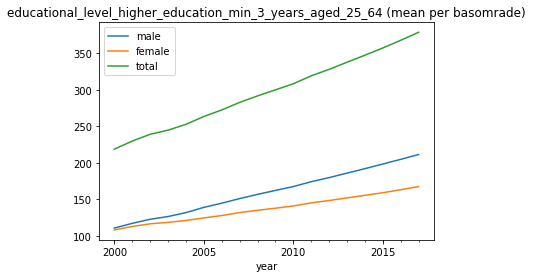

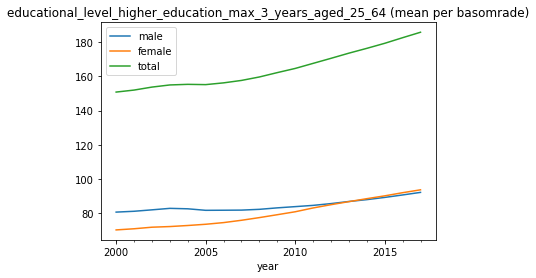

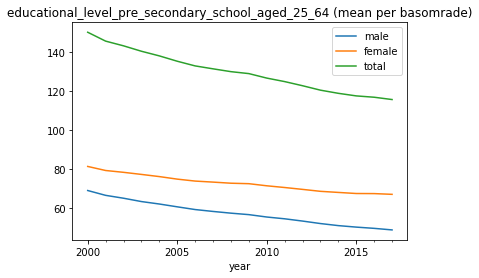

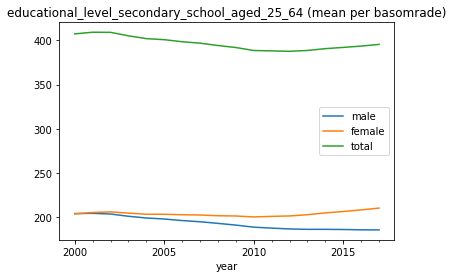

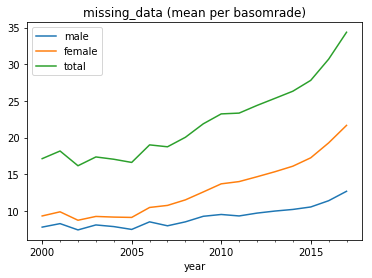

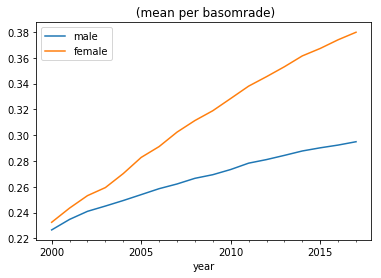

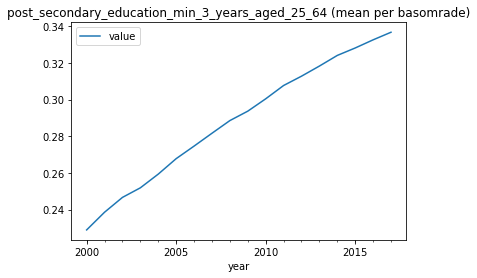

In [2]:
%run educational_level.ipynb

----

----

----

## Befolkning 25-64

Processas i en separat notebook: [population_25_64](population_25_64.ipynb)

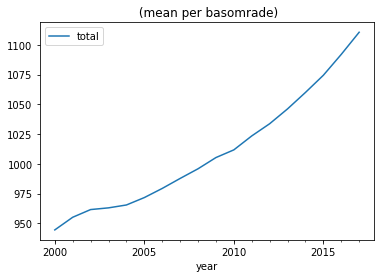

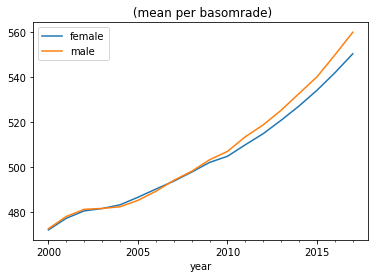

In [3]:
%run population_25_64.ipynb

----

----

----

## Sysselsättning

Processas i en separat notebook: [employed](employed.ipynb)

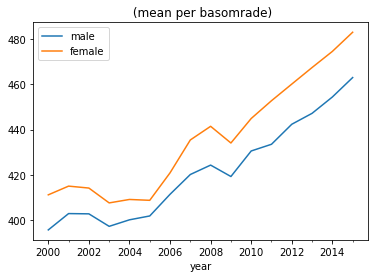

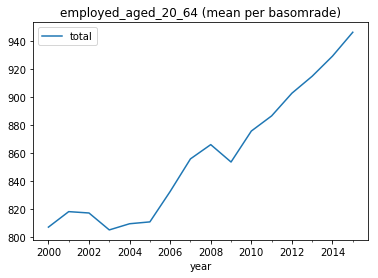

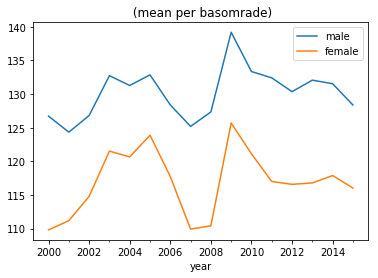

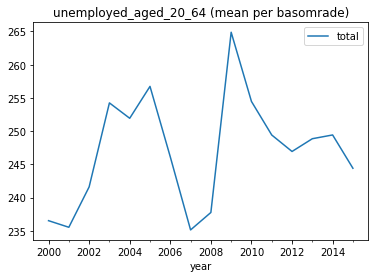

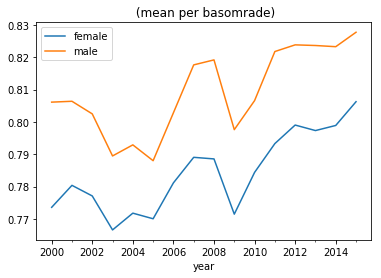

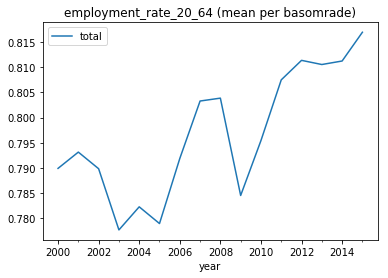

In [4]:
%run employed.ipynb

----

----

----

## Befolkning 20-64

Processas i en separat notebook: [population_20_64](population_20_64.ipynb)

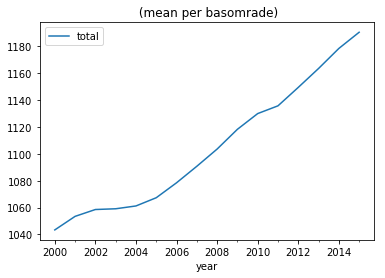

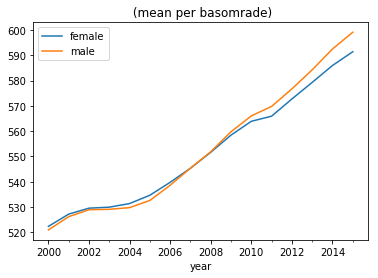

In [5]:
%run population_20_64.ipynb

----

----

----

## Medelinkomst

Processas i en separat notebook: [mean_income](mean_income.ipynb)

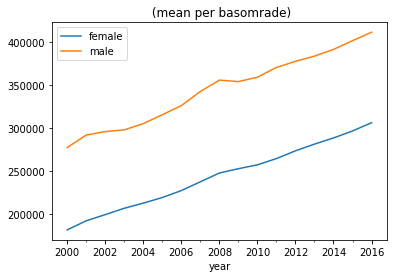

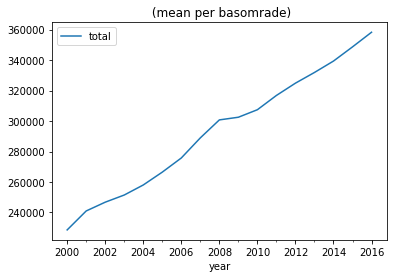

In [6]:
%run mean_income.ipynb

----

----

----


## Upplåtelseform bostäder

Processas i en separat notebook: [andel_aegender](andel_aegender.ipynb)

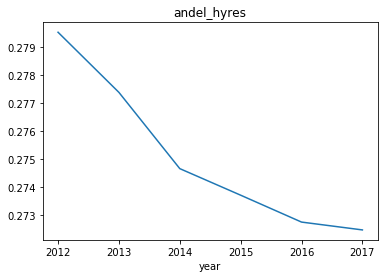

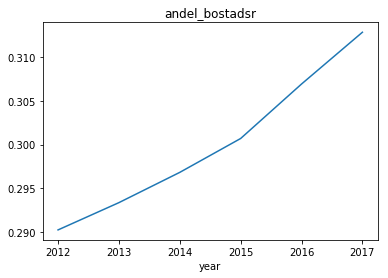

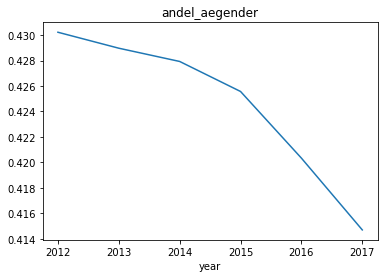

In [7]:
%run andel_aegender.ipynb

----

----

----

## Totalbefolkning

Processas i en separat notebook: [population_total](population_total.ipynb)

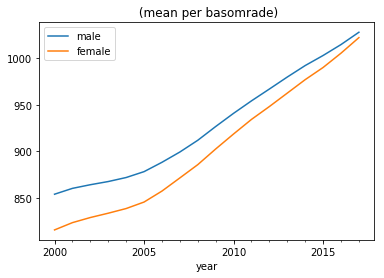

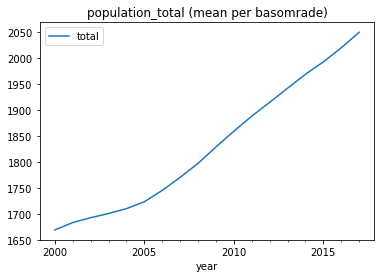

In [8]:
%run population_total.ipynb

-----
----
----

## Nettoflytt

### Antal

Processas i en separat notebook: [immigration_surplus_employed_aged_20_64](immigration_surplus_employed_aged_20_64.ipynb)

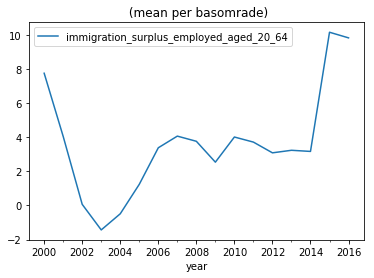

In [9]:
%run immigration_surplus_employed_aged_20_64.ipynb

### Kumulativ

Processas i en separat notebook: [cumulative_immigration_surplus_employed_aged_20_64](cumulative_immigration_surplus_employed_aged_20_64.ipynb)

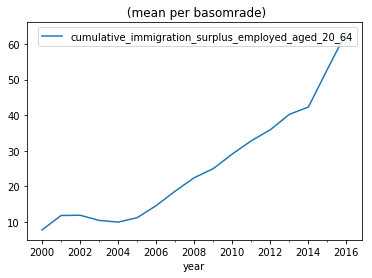

In [10]:
%run cumulative_immigration_surplus_employed_aged_20_64.ipynb

---
---
---

## Nettoflytt, längre utbildning

Något fel med indatan, avvaktar (cellerna inaktiverade med raw-mode)

### Antal

Processas i en separat notebook: [immigration_surplus_min_3_years_of_higher_education_aged_25_64](immigration_surplus_min_3_years_of_higher_education_aged_25_64.ipynb)

### Kumulativ

Processas i en separat notebook: [cumulative_immigration_surplus_min_3_years_of_higher_education_aged_25_64](cumulative_immigration_surplus_min_3_years_of_higher_education_aged_25_64.ipynb)

---
---
---

## Antal rum

Processas i en separat notebook: [n_rooms](n_rooms.ipynb)

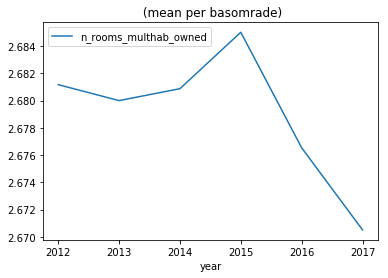

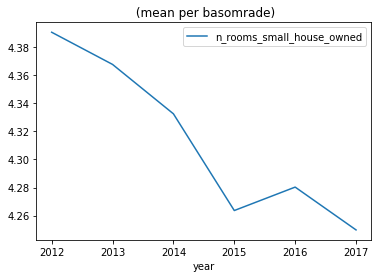

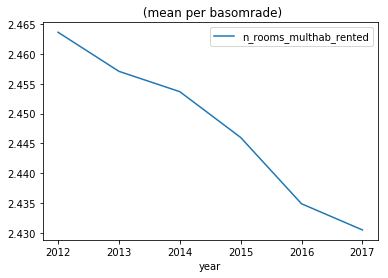

In [11]:
%run n_rooms.ipynb

## Bilar

[cars](cars.ipynb)

14
['Basområde', 'Antalpersoner', 'Antal personer med bil', 'Därav leasing', 'Antal bilar i trafik', 'Därav leasing', 'Antal avställda bilar', 'Därav leasing', 'Antal personersom skattatför förmånsbil', 'Antal personersom skattatmen ej skattatför förmånsbil', 'Antalhushåll', 'Antalhushållmed bil', 'Antal hushållmed fler änen bil', 'year']


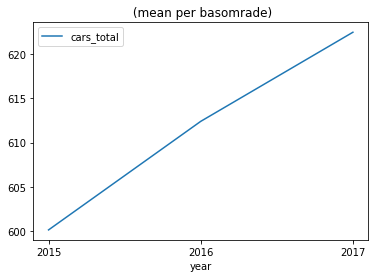

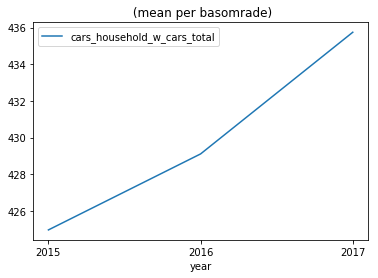

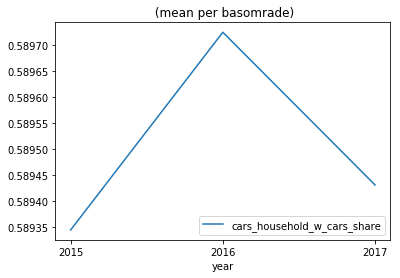

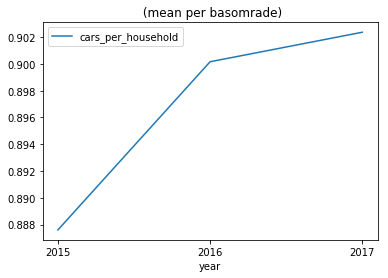

In [12]:
%run cars.ipynb

## Ekonomiskt bistånd

[ekbist](ekbist.ipynb)

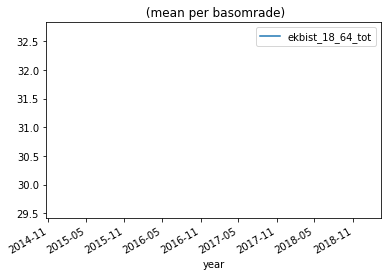

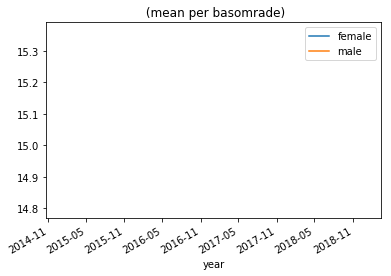

In [2]:
%run ekbist.ipynb

## Åk 3, SV Andel

[education_year_3_sv](education_year_3_sv.ipynb)

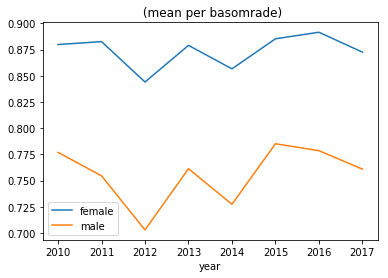

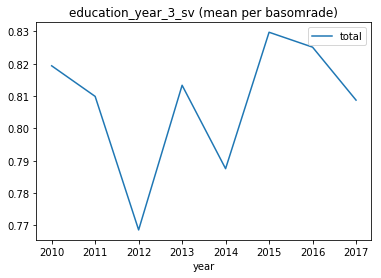

In [2]:
%run education_year_3_sv.ipynb